In [106]:
import requests
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
tqdm.pandas()

Clean DOI

In [107]:
path='../IPCC_bibliography/AR6/structured_data/'

In [108]:
#data for each wg
df_wgi = pd.read_json(path+'data_wg1.jsonl', lines= True)
df_wgii = pd.read_json(path+'data_wg2.jsonl', lines= True)
df_cross_wgii = pd.read_json(path+'data_cross_wg2.jsonl', lines= True)
df_wgiii = pd.read_json(path+'data_wg3.jsonl', lines= True) 

In [109]:
#all data
df_ipcc=pd.concat([df_wgi, df_wgii, df_cross_wgii, df_wgiii], ignore_index=True)

In [110]:
def get_doi_cleaned(x):
    low_x=str(x).lower()
    if pd.isna(x):
        return None
    if low_x.find('https://doi.org/')>0:
        return low_x.replace('https://doi.org/','')
    else:
        return low_x

In [111]:
df_ipcc['doi']=df_ipcc.loc[:,'doi'].apply(lambda x: get_doi_cleaned(x))

Get open_access, sdg, countries from OpenAlex

In [112]:
def aplatir(conteneurs):
    return [conteneurs[i][j] for i in range(len(conteneurs)) for j in range(len(conteneurs[i]))]

In [113]:
json_OA=[]
def get_open_alex_data(row):
    doi=row.doi
    if pd.isna(doi)==False:
        url=f"https://api.openalex.org/works?filter=doi:{doi}"
        response = requests.get(url)
        data = response.json()
        if 'results' in data.keys():
            json_OA.append({"doi": doi, "results": data.get('results')})
        else:
            json_OA.append({"doi": doi, "results": []})

In [114]:
def get_status_sdg_coutries(df,row):
    doi=row.doi
    data=df[df.doi==doi]
    i=df[df.doi==doi].index[0]
    if data['results'][i]!=[]:
        open_access=data['results'][i][0].get('open_access')
        if open_access!={}:
            status={'is_oa':open_access.get('is_oa'),'oa_status':open_access.get('oa_status')}
        else:
            status=None

        sdgs=data['results'][i][0].get('sustainable_development_goals')
        if sdgs!=[]:
            sdgs_id_name=[{'id': str(sdg.get('id'))[-2:].replace("/",""), 'name': sdg.get('display_name')} for sdg in sdgs]
        else:
            sdgs_id_name=None

        authors=data['results'][i][0].get('authorships')
        if authors!=[]:
            countries=list(set(aplatir([author.get('countries') for author in authors]))) 
        else:
            countries=[None]
    else:
        return None,None,[None]

    return status, sdgs_id_name, countries

In [115]:
#get data_OpenAlex from the API (6h)
""" df_unique_doi=df_ipcc.drop_duplicates(subset=['doi'])
df_unique_doi.loc[:,'doi']=df_unique_doi.loc[:,'doi'].apply(lambda x: None if str(x)[:4]=='http' else x)
df_unique_doi=df_unique_doi.dropna(subset=['doi'])
df_unique_doi.progress_apply(get_open_alex_data, axis= 1)
pd.DataFrame(json_OA).to_json(path+'data_OpenAlex.json', orient='records') """

" df_unique_doi=df_ipcc.drop_duplicates(subset=['doi'])\ndf_unique_doi.loc[:,'doi']=df_unique_doi.loc[:,'doi'].apply(lambda x: None if str(x)[:4]=='http' else x)\ndf_unique_doi=df_unique_doi.dropna(subset=['doi'])\ndf_unique_doi.progress_apply(get_open_alex_data, axis= 1)\npd.DataFrame(json_OA).to_json(path+'data_OpenAlex.json', orient='records') "

In [116]:
#get data_OpenAlex from the file
data_OpenAlex_all=pd.read_json(path+'data_OpenAlex.json')

In [118]:
status_list = []
sdg_list = []
countries_list = []
for i,row in data_OpenAlex_all.iterrows():
    status, sdg, countries=get_status_sdg_coutries(data_OpenAlex_all,row)

    status_list.append(status)
    sdg_list.append(sdg)
    countries_list.append(countries)

data_OpenAlex_all['status'] = status_list
data_OpenAlex_all['sdg'] = sdg_list
data_OpenAlex_all['countries'] = countries_list

In [144]:
data_OpenAlex=data_OpenAlex_all[['doi','status','sdg','countries']]

The part of each countries in ipcc references

In [ ]:
df_ipcc=pd.merge(df_ipcc, data_OpenAlex, on='doi', how='left')
df_ipcc.loc[:,'countries']=df_ipcc.loc[:,'countries'].apply(lambda x: str(x).replace('nan','None').replace('[]','None').replace('[None]','None') if ((str(x)=='nan')|(str(x)=='[None]')|((str(x)=='[]'))) else x )
df_ipcc.loc[:,'countries']=df_ipcc.loc[:,'countries'].apply(lambda x: ['None'] if x=='None' else x)

In [ ]:
data_counts = pd.Series(aplatir(list(df_ipcc['countries']))).value_counts()

In [ ]:
plt.figure(figsize=(10, 6))
data_counts[:20].plot(kind='bar')
ax = data_counts[:20].plot(kind='bar')
for i, v in enumerate(data_counts[:20]):
    ax.text(i, v + 0.1, str(v), ha='center', va='bottom')
plt.show()

The part of each countries in WG1 references

In [ ]:
df_wgi=pd.merge(df_wgi, data_OpenAlex, on='doi', how='left')
df_wgi.loc[:,'countries']=df_wgi.loc[:,'countries'].apply(lambda x: str(x).replace('nan','None').replace('[]','None').replace('[None]','None') if ((str(x)=='nan')|(str(x)=='[None]')|((str(x)=='[]'))) else x )
df_wgi.loc[:,'countries']=df_wgi.loc[:,'countries'].apply(lambda x: ['None'] if x=='None' else x)

In [ ]:
data_counts = pd.Series(aplatir(list(df_wgi['countries']))).value_counts()

In [ ]:
plt.figure(figsize=(10, 6))
data_counts[:20].plot(kind='bar')
ax = data_counts[:20].plot(kind='bar')
for i, v in enumerate(data_counts[:20]):
    ax.text(i, v + 0.1, str(v), ha='center', va='bottom')
plt.show()

SDG in IPCC references

In [ ]:
sdg_names=data_OpenAlex.loc[:,'sdg'].dropna().apply(lambda x: str(x[0].get('name')).lower().replace(',',''))

In [ ]:
data_counts = pd.Series(list(sdg_names)).value_counts()

In [ ]:
plt.figure(figsize=(6, 10))
plt.pie(data_counts, labels=data_counts.index, autopct='%1.1f%%', startangle=140)
plt.subplots_adjust(wspace=0.5, hspace=1)
plt.show()

Open status

In [146]:
status=data_OpenAlex.loc[:,'status'].dropna().apply(lambda x: str(x.get('oa_status')))

In [147]:
data_counts = pd.Series(list(status)).value_counts()

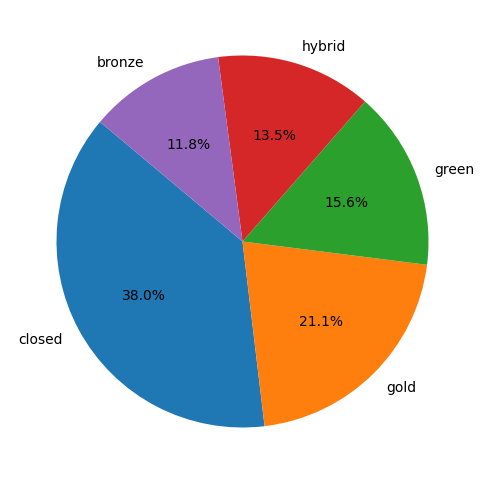

In [148]:
plt.figure(figsize=(6, 10))
plt.pie(data_counts, labels=data_counts.index, autopct='%1.1f%%', startangle=140)
plt.subplots_adjust(wspace=0.5, hspace=1)
plt.show()

Get concepts from OpenAlex

In [122]:
def get_concepts(df,row):
    doi=row.doi
    data=df[df.doi==doi]
    i=df[df.doi==doi].index[0]
    if data['results'][i]!=[]:
        concepts=data['results'][i][0].get('concepts')
        if concepts!=[]:
            concepts_name=[{'name': concept.get('display_name')} for concept in concepts]
        else:
            concepts_name=None
    else:
        return None
    return concepts_name

In [124]:
concepts_list = []
for i,row in data_OpenAlex_all.iterrows():
    concepts=get_concepts(data_OpenAlex_all,row)
    concepts_list.append(concepts)

data_OpenAlex_all['concepts'] = concepts_list

In [127]:
concepts_names=data_OpenAlex_all.loc[:,'concepts'].dropna().apply(lambda x: str(x[0].get('name')).lower().replace(',',''))

In [143]:
data_counts

climate change           3085
environmental science    2048
climatology              1633
greenhouse gas            879
precipitation             599
                         ... 
urban green space           1
bailout                     1
spider mite                 1
voltinism                   1
curse                       1
Name: count, Length: 4965, dtype: int64

In [132]:
data_counts = pd.Series(list(concepts_names)).value_counts()

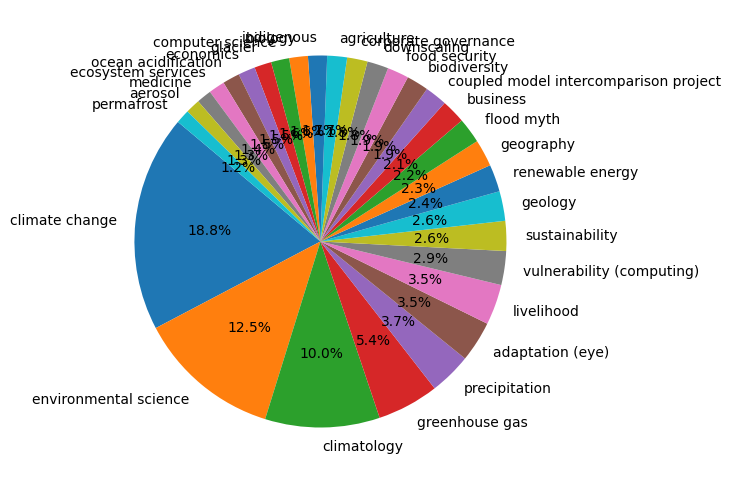

In [142]:
plt.figure(figsize=(6, 10))
plt.pie(data_counts[:30], labels=data_counts[:30].index, autopct='%1.1f%%', startangle=140)
plt.subplots_adjust(wspace=0.5, hspace=1)
plt.show()